In [24]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from random import randint, random
from time import sleep
import math
from scipy.stats import poisson
import seaborn as sns; sns.set()

In [25]:
# parameters of the demand model
true_slop = 30
true_intercept = -0.5

#simulation data
num_episodes = 1000

#parameters: 40 items, 5 different prices, and 20 days to the final day
stock = 40
prices = [19, 25, 30, 35, 40, 45]
horizon_steps = 20

<h1>Agent</h1>

This agent applies a policy that could be a random policy or a Designed optimal policy (our target)

In [26]:
def agent(policy, starting_position=None, verbose=False):

    agent_position = starting_position
        
    revenue = 0
    action_taken = None
    
    #while not (agent_position == 0):
    for step in range(horizon_steps):
        current_policy = policy[agent_position,step,:]
        next_move = random()
        lower_bound = 0
        demand = 0
        for action in range(len(prices)):
            chance = current_policy[action]
            if chance == 0:
                continue
            if lower_bound <= next_move < lower_bound + chance:
                demand = retrieve_linear_demand(action, step)
                #print("action: {} demand: {}".format(action, demand))
                if (agent_position >= demand ):
                    agent_position = agent_position - demand
                else:
                    demand = agent_position
                    agent_position = 0
                action_taken = action
                break 
            lower_bound = lower_bound + chance
                
        revenue = revenue + demand * prices[action] 
        
        if verbose:
            clear_output(wait=True)
            print("New Demand: {} Revenue acum: {} Remain Stock: {} Price: {}".format(demand, revenue, agent_position, prices[action_taken]))
            print("\n")
            sleep(1)
                
    return revenue

$$\lambda = 30 - 0.5p + 0.1e^{t/4}$$

In [27]:
#this gives us the average demand from a (price) and h (time)
def retrieve_deterministic_demand(a, h):
    return true_slop + true_intercept * prices[a] +0.1*math.exp(h/4)

In [28]:
#this gives us an stochastic demand
def retrieve_linear_demand(a, h): 
    demand = retrieve_deterministic_demand(a, h)
    return np.random.poisson(demand, 1)[0]

Text(0.5, 0, 'demand')

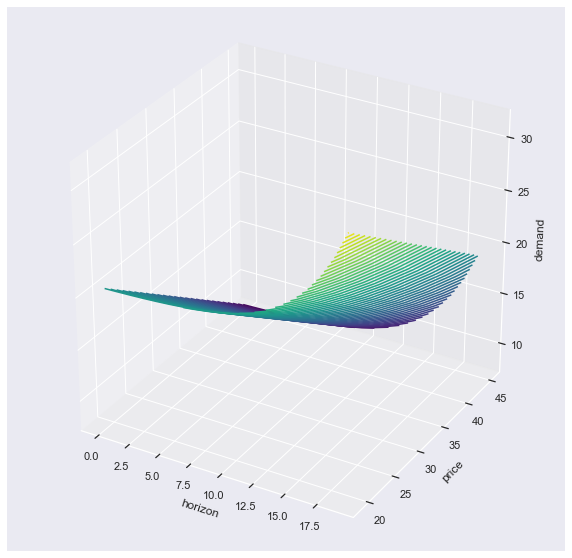

In [29]:
#we plot the demand in 3D

from mpl_toolkits import mplot3d

h = np.linspace(0, horizon_steps-1, horizon_steps)
p = np.asarray(prices)
X, Y = np.meshgrid(h, p)

def f(x, y):
    return true_slop + true_intercept * y +0.1*np.exp(x/4)

Z = f(X, Y)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='viridis')
ax.set_xlabel('horizon')
ax.set_ylabel('price')
ax.set_zlabel('demand')

<h1>Probability distribution</h1>

We calculate de probability from states derived from poisson formula

In [30]:
def probability_demand(x1, x2, a, h):
    demand = retrieve_deterministic_demand(a, h)
    k = x1 - x2
    rv = poisson(demand)
    return rv.pmf(k)

In [31]:
def create_probability_map():
    probability_map = np.zeros((stock+1, horizon_steps, stock+1, horizon_steps, len(prices)),dtype=float)
    states = list(range(stock+1))
    steps = list(range(horizon_steps))

    for horizon_from in steps:
        for state_from in states:
            for price in range(len(prices)):
                for horizon_to in steps:
                    prob_tot = 0
                    for state_to in reversed(states):
                        if (horizon_to != (horizon_from+1)) or (state_to > state_from):
                            prob = 0
                        else:
                            prob = probability_demand(state_from, state_to, price, horizon_from)
                            prob_tot = prob_tot + prob
                            if (state_to == 0):
                                prob = prob + ( 1 - prob_tot )
                        probability_map[state_from][horizon_from][state_to][horizon_to][price] = prob
                        #print("prob {} {} {}: {}".format(state_from, state_to, price, prob))
    return probability_map

In [32]:
result = create_probability_map()

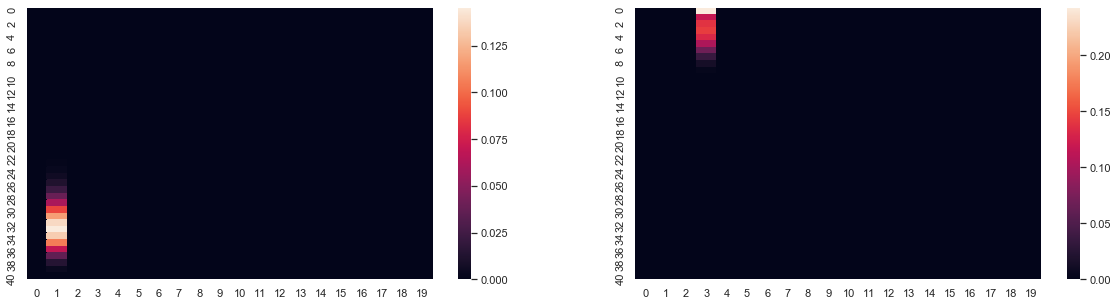

In [33]:
# Soms subplots to inspect how the probability behaves
fig = plt.figure(figsize=(20,5))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

sns.heatmap(result[stock,0,:,:,5], ax=ax1)
sns.heatmap(result[10,2,:,:,5], ax=ax2)

<h1>Create greedy policy based on poisson probs V(s)</h1>

We test 1000 dandom episodes with the agent aplying a random policy

<h1>Random Policy test</h1>

In [34]:
def create_random_policy():
    policy = np.zeros((stock+1, horizon_steps, len(prices)),dtype=float)

    for horizon in range(horizon_steps-1):
        for state in range(stock+1):    
            for p in range(len(prices)):
                policy[state][horizon][p] = 1 / len(prices)
    return policy

In [35]:
data = []

for i in range(num_episodes):
    clear_output(wait=True)
    print("{}%\n".format((i + 1) * 100 / num_episodes))
    data.append(agent(create_random_policy(), starting_position=stock, verbose=False))
    
print("Average revenue (average total income): {}".format(sum(data)/len(data)))

100.0%

Average revenue (average total income): 1182.516


<h1>Value iteration</h1>

We calculate optimal policy from Value Iteration Bellman Equation

In [36]:
def create_greedy_policy(A_s):

    policy = np.zeros((stock+1, horizon_steps, len(prices)),dtype=float)
    for horizon in range(horizon_steps):
        for state in range(stock+1):
            for a in range(len(prices)):
                if a == A_s[state][horizon]:
                    policy[state][horizon][a] = 1
    return policy

In [37]:
def value_iteration(V_s, theta=0.01, discount_rate=0.5):
    probabilitiy_map = create_probability_map()
    
    A_s = np.zeros((stock+1, horizon_steps),dtype=int)
    
    states = list(range(stock+1))
    horizons = list(range(horizon_steps))
    
    delta = 100
    while not delta < theta:
        delta = 0
        for horizon in reversed(horizons):
            for state in states:
                v = V_s[state][horizon]
                totals = {}
                for action in range(len(prices)):
                    total = 0
                    if horizon + 1 < horizon_steps:
                        for state_prime in states:
                            reward = ( state - state_prime ) * prices[action]
                            total += probabilitiy_map[state][horizon][state_prime][horizon+1][action] * (reward + discount_rate * V_s[state_prime][horizon+1])
                    totals[action] = total
                V_s[state][horizon] = round(max(totals.values()), 4)
                f = lambda i: totals[i]
                A_s[state][horizon] = max(range(len(totals)), key=f)
                delta = max(delta, abs(v - V_s[state][horizon]))
    return V_s, A_s

In [38]:
V_s = np.zeros((stock+1, horizon_steps),dtype=float)
V_s, A_s = value_iteration(V_s)
policy = create_greedy_policy(A_s)

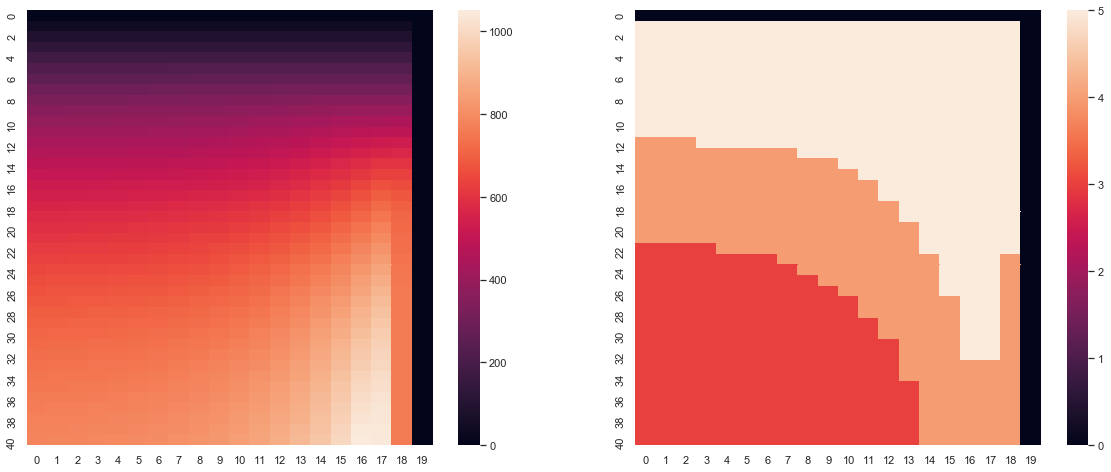

In [39]:
# Soms subplots to inspect how the probability behaves
fig = plt.figure(figsize=(20,8))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

sns.heatmap(V_s, ax=ax1)
sns.heatmap(A_s, ax=ax2)

In [40]:
data = []

for i in range(num_episodes):
    clear_output(wait=True)
    print("{}%\n".format((i + 1) * 100 / num_episodes))
    data.append(agent(policy, starting_position=stock, verbose=False))
    
print("Average revenue: {}".format(sum(data)/len(data)))

100.0%

Average revenue: 1503.59
